## Regression with image segmentation and steering values

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import pandas as pd
from PIL import Image

## Getting and converting the data

In [3]:
path = Path('data/imageSeg/labels')

In [6]:
#Open up each screenshot in labels, simplify masks, and save to another folder.

# filename = 'ScreenShot00695_P.png'
# img = open_image(path/filename)
# x = image2np(img.data*7e3).astype(np.uint8)
# mask = (x != 82) & (x != 247)
# x[mask] = 0
# # PIL.Image.fromarray(x).save(path/'../regression_images'/filename, 'png')
# PIL.Image.fromarray(x).save(path/'..'/filename, 'png')

# for filename in os.listdir(path):
#     if not (filename.endswith('.png')):
#         continue
        
#     img = open_image(path/filename)
#     x = image2np(img.data*7e3).astype(np.uint8)
#     mask = (x != 82) & (x != 247)
#     x[mask] = 0
#     PIL.Image.fromarray(x).save(path/'../regression_images'/filename, 'png')

## Crop images. I found that the predictions were better when the images were cropped so that only the bottom half still remained.

In [64]:
# path = Path('data/imageSeg/regression_images')
# fname = path/'capture00257.jpg'
# img = Image.open(fname)
# w, h = img.size
# img = img.crop((0, h-130, w, h))
# img.save('data/imageSeg/tmp.png', 'png')

path = Path('data/imageSeg/regression_images')
    
for filename in os.listdir(path):
    if not (filename.endswith('.jpg')):
        continue
        

    fname = path/filename
    img = Image.open(fname)
    w, h = img.size
    img = img.crop((0, h-130, w, h))
    img.save(path/filename, 'jpeg')

In [65]:
path = Path('data/imageSeg/regression_images')
fname = path/'capture00257.jpg'

torch.Size([3, 130, 760])

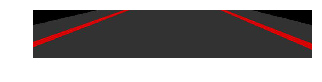

In [71]:
mask = open_image(fname)
mask.show(figsize=(5,5), alpha=1)
mask.shape

In [67]:
# Read in Unreal generated steering data as dataframe and convert to an array.
df = pd.read_csv(path/'../steeringValues.csv', index_col=0)        
steerValues = df['Axis Value']
steerValues = steerValues.values
steerValues.size

655

In [68]:
# get index of steering value from file name slice

def get_steer(f):
    f = str(f)
    f = f[39:44]
    f = int(f)
    
    return steerValues[f]

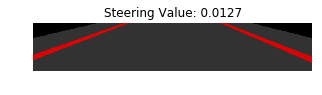

In [69]:
#show mask with steering value as title
mask.show(figsize=(5,5), title=('Steering Value: ' + str(get_steer(fname))), alpha=1)

## Creating a dataset

In [72]:
# data = (PointsItemList.from_folder(path)
#         .split_by_valid_func(lambda o: o.parent.name=='13')
#         .label_from_func(get_ctr)
#         .transform(get_transforms(), tfm_y=True, size=(120,160))
#         .databunch().normalize(imagenet_stats)
#        )

data = (ImageList.from_folder(path)
        .random_split_by_pct(0.2, seed=2)
        .label_from_func(get_steer)
        .transform(get_transforms(do_flip=False, max_rotate=0.0, max_zoom=1.2, max_warp=0.0, p_affine=0.5), size=(65, 380))
        .databunch(bs=16).normalize(imagenet_stats)
       )

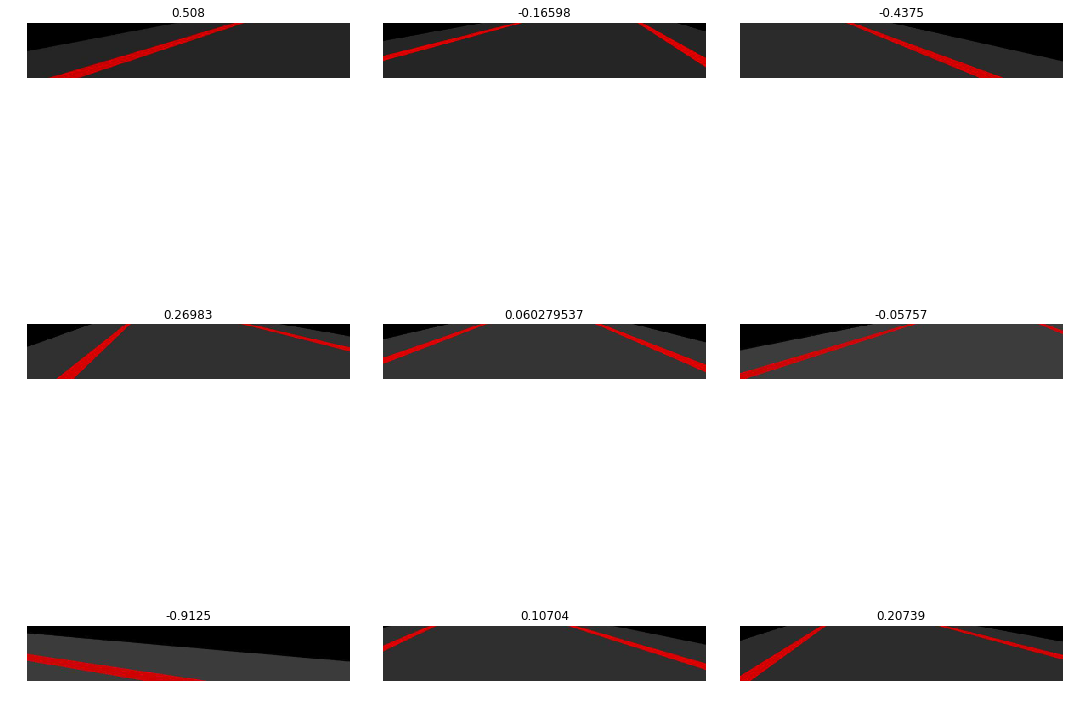

In [73]:
data.show_batch(3, figsize=(15,15))

In [74]:
data.valid_ds

LabelList (131 items)
x: ImageList
Image (3, 65, 380),Image (3, 65, 380),Image (3, 65, 380),Image (3, 65, 380),Image (3, 65, 380)
y: FloatList
0.6731,-0.5125,-0.40917,-0.42089,-0.4625
Path: data/imageSeg/regression_images

## Train model

In [75]:
learn = create_cnn(data, models.resnet34, wd=1e-1, ps=0.3)
learn.loss_func
# learn.loss_func = MSELossFlat()

FlattenedLoss of MSELoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


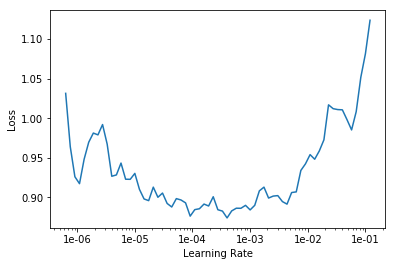

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
lr = 1e-3

In [78]:
learn.fit_one_cycle(20, lr, wd=2e-1)

epoch,train_loss,valid_loss,time
1,0.892139,0.331391,00:03
2,0.837953,0.318176,00:02
3,0.771586,0.350438,00:02
4,0.678762,0.256817,00:02
5,0.601694,0.219581,00:02
6,0.525245,0.229697,00:02
7,0.445427,0.092249,00:02
8,0.355358,0.119513,00:02
9,0.289234,0.044698,00:02
10,0.235690,0.076362,00:02


In [79]:
learn.save('stage-1_temp')

In [80]:
learn.load('stage-1_temp');
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


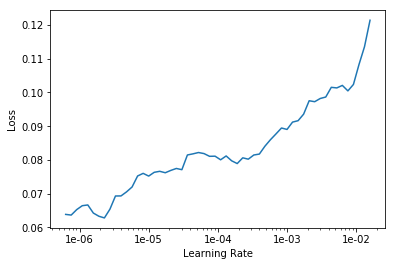

In [81]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(20, slice(1e-5, lr/10))

epoch,train_loss,valid_loss,time
1,0.061551,0.007685,00:03
2,0.062914,0.008431,00:03
3,0.063875,0.013542,00:03
4,0.066894,0.016409,00:03
5,0.068735,0.022289,00:03
6,0.073024,0.020848,00:03
7,0.070544,0.023727,00:03
8,0.069176,0.089433,00:03
9,0.069224,0.010338,00:03
10,0.067297,0.008630,00:03


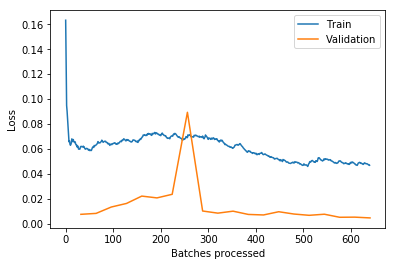

In [84]:
learn.recorder.plot_losses()

In [85]:
learn.save('stage-2')

In [14]:
learn.load('stage-2');

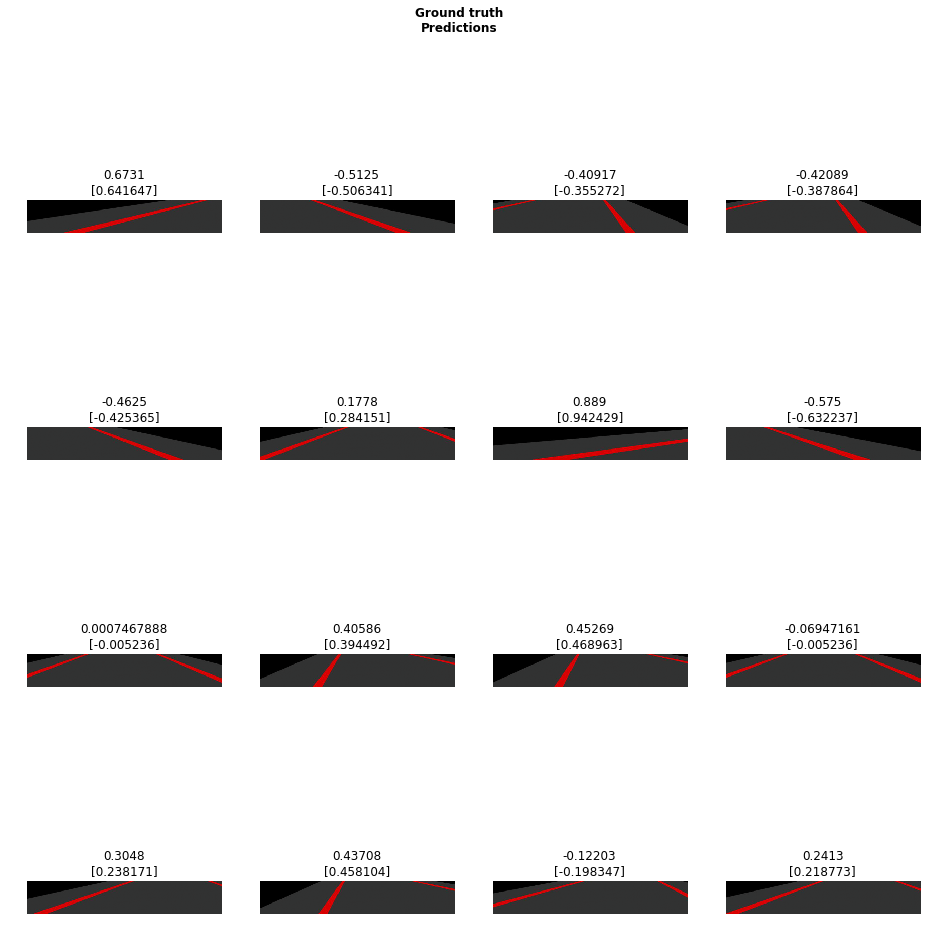

In [86]:
learn.show_results()

## Prediction

In [87]:
learn.export('export_steerPredict.pkl')

In [21]:
learn = load_learner(path, 'export_steerPredict.pkl')

## Get a prediction on one file and see if it's close to ground truth

[0.9736551642417908]


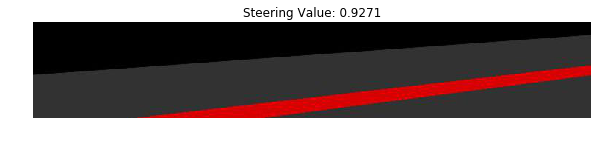

In [88]:
#Title is ground truth, tensor is prediction
filename = 'capture00185.jpg'
img = open_image(path/filename)
img.show(figsize=(10,10), title=('Steering Value: ' + str(get_steer(path/filename))))
value = learn.predict(img)[1]
value = value.data.tolist()
print(value)